In [1]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
from tqdm import tqdm
from time import time
import json
import torch
import SimpleITK as sitk
from natsort import natsorted

import warnings
warnings.filterwarnings('ignore')


In [3]:
from src.scripts.models.U2Net import U2Net 
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms.v2 as transforms
from src.scripts.DataLoaders import ImgForPlot

In [4]:
import pickle
import torch.nn as nn
from src.scripts.losses import IoULoss, DiceBCELoss, DiceLoss

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# Check available GPU memory and total GPU memory 
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")


Total free GPU memory: 7.075 GB
Total GPU memory: 8.358 GB


In [7]:
class MyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        """ """
        assert len(image_paths) == len(mask_paths)
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.image_paths[index]
        msk_path = self.mask_paths[index]
        image = self.load_image(img_path, as_mask=False)
        mask = self.load_image(msk_path, as_mask=True)
        
        if self.transform:
            # image, mask = self.transform(image, mask)
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask
    
    def __len__(self):
        return len(self.image_paths)
    
    def load_image(self, path, as_mask=False):
        if as_mask:
            img = cv2.imread(path, 0)
            img = np.where(img > 0, 1., 0.)
        else:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img / 255

        img = img.astype(np.float32)

        return img

In [8]:
def get_paths(main_path):
    img_paths = [os.path.join(main_path, "images", img_name) for img_name in os.listdir(os.path.join(main_path, 'images'))]
    msk_paths = [os.path.join(main_path, "masks", img_name) for img_name in os.listdir(os.path.join(main_path, 'masks'))]
    img_paths = natsorted(img_paths)
    msk_paths = natsorted(msk_paths)

    return img_paths, msk_paths


train_path = 'data/train/echoLA/training'
test_path = 'data/train/echoLA/testing'

train_img_paths, train_msk_paths = get_paths(train_path)
test_img_paths, test_msk_paths = get_paths(test_path)

train_img_paths[:5], train_msk_paths[:5]

(['data/train/echoLA/training/images/mhd_patient0001_2CH_ED.jpg',
  'data/train/echoLA/training/images/mhd_patient0001_2CH_ES.jpg',
  'data/train/echoLA/training/images/mhd_patient0001_4CH_ED.jpg',
  'data/train/echoLA/training/images/mhd_patient0001_4CH_ES.jpg',
  'data/train/echoLA/training/images/mhd_patient0002_2CH_ED.jpg'],
 ['data/train/echoLA/training/masks/mhd_patient0001_2CH_ED_gt.png',
  'data/train/echoLA/training/masks/mhd_patient0001_2CH_ES_gt.png',
  'data/train/echoLA/training/masks/mhd_patient0001_4CH_ED_gt.png',
  'data/train/echoLA/training/masks/mhd_patient0001_4CH_ES_gt.png',
  'data/train/echoLA/training/masks/mhd_patient0002_2CH_ED_gt.png'])

In [9]:
len(train_img_paths)

20997

In [10]:
# Write transform for image
data_transform = transforms.Compose([
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    # transforms.Resize(size=(512, 512)),
])

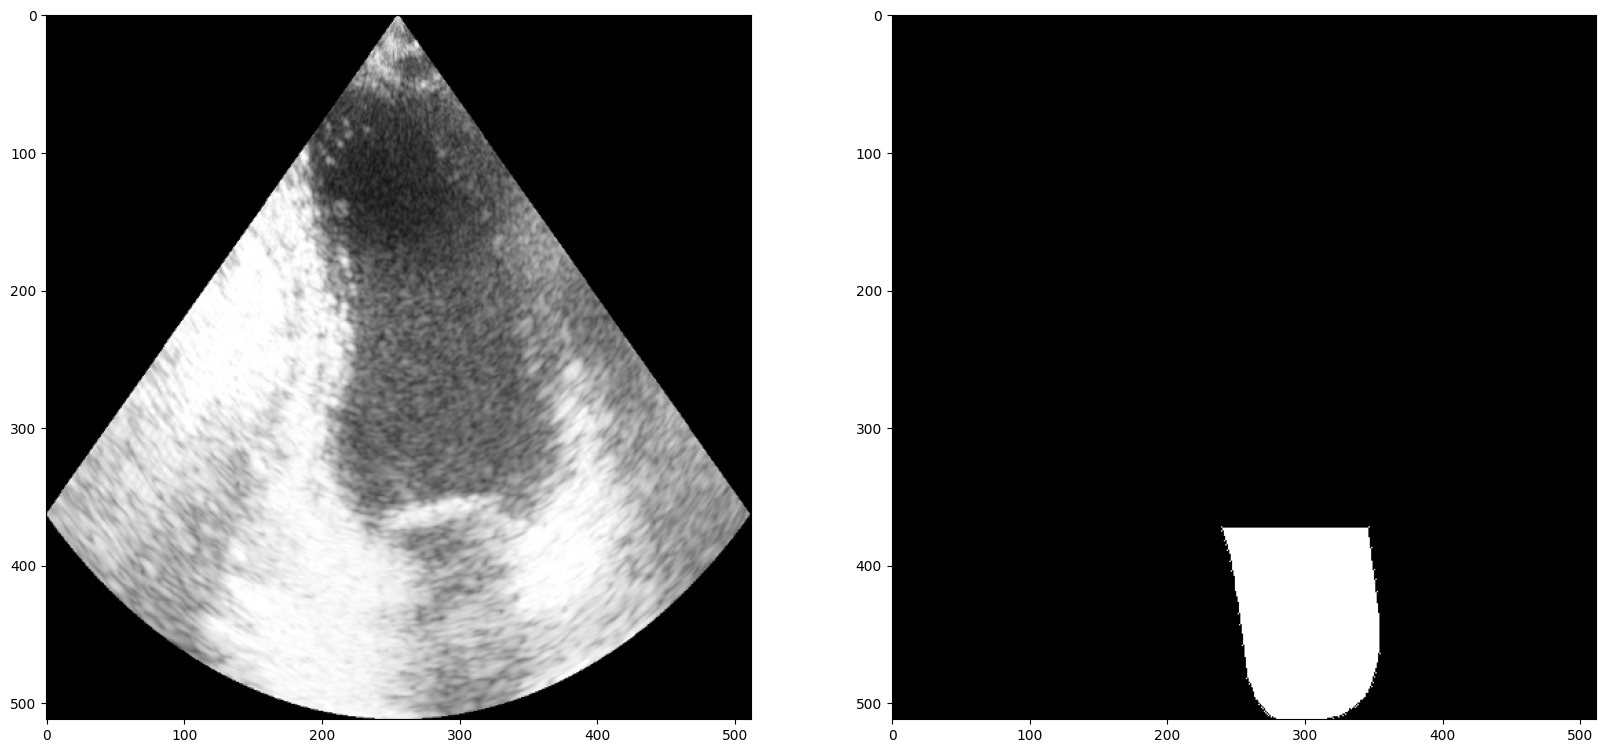

In [11]:
# 
train_dataset = MyDataset(train_img_paths, train_msk_paths, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = MyDataset(test_img_paths, test_msk_paths, transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

im, m = next(iter(train_dataset))
fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');

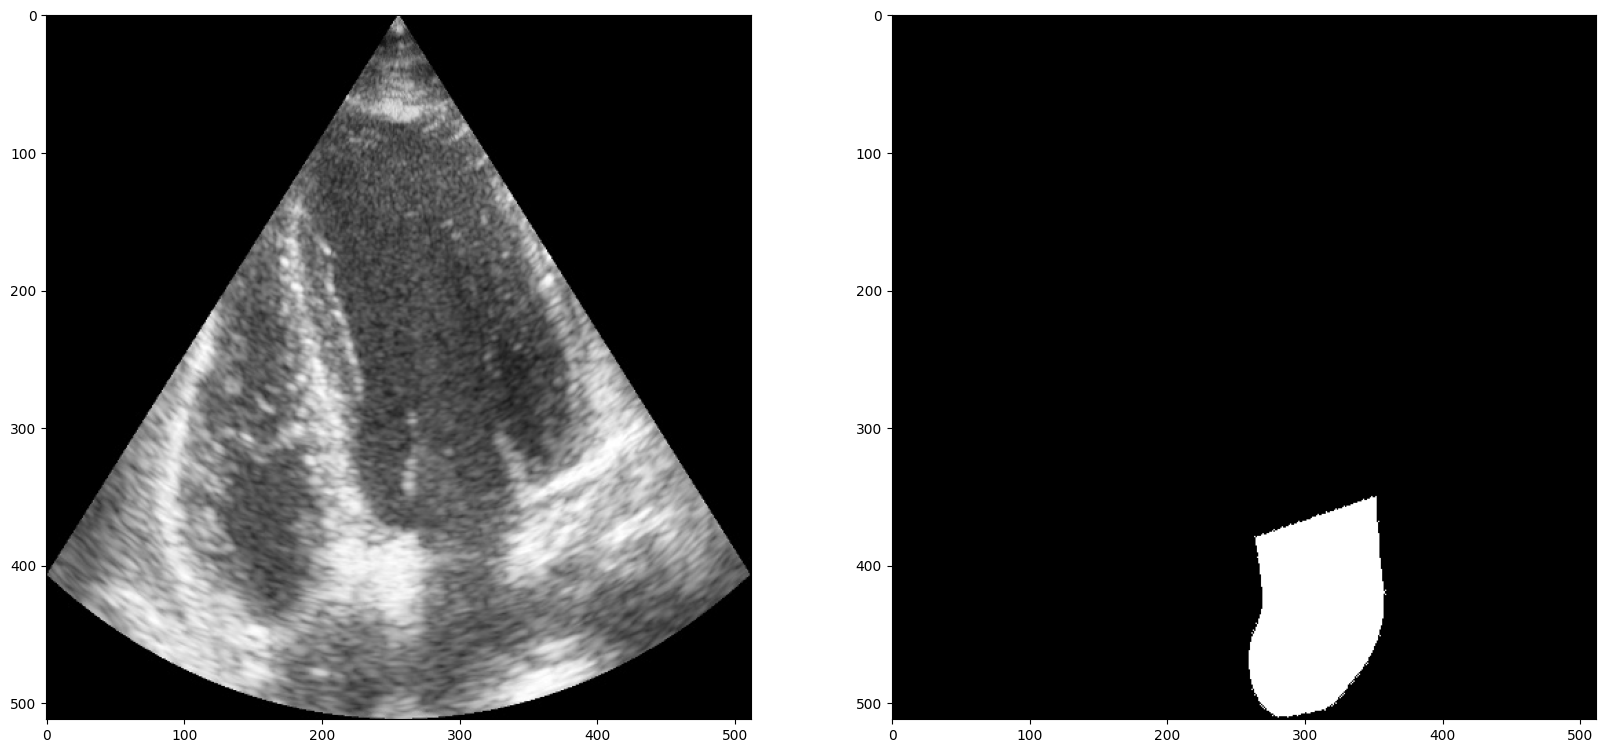

In [12]:
im, m = train_dataset[10]
fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');

In [13]:
# 
lr = 0.001

model_saved_dir = "results/U2Net"
if os.path.exists(model_saved_dir) == False:
    os.mkdir(model_saved_dir)
model_name = 'u2net-LA'
loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}_best.pt"
best_model_path = model_path

# with open(loss_path, 'rb') as f:
#   losses = pickle.load(f)

model = U2Net().to(device)
# Continue lerning
# model.load_state_dict(torch.load(model_path))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

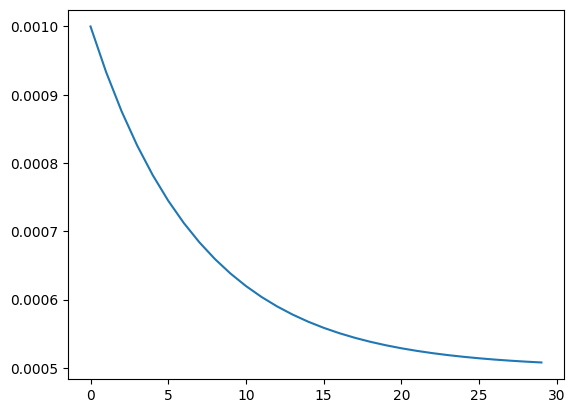

In [14]:
LR_START = 0.001
T_alpha = 7   # Time constant, чем меньше тем быстрее
LOW = 0.0005 # 0.0002
epochs = 30

def ws_lr(epoch, lr):
    return (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW

xx = np.arange(30)

plt.plot(xx, [ws_lr(x, 0.01) for x in xx])

In [15]:
import math


def update_lr(epoch, T):
  # Decrease lr every T epochs
  new_lr = (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW  # lr * math.pow(0.5, epoch // T)
  print('Learning Rate: %.6f' % new_lr)
  for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr

In [16]:
# BCE = nn.BCELoss(reduction='mean')  # Train
BCE = nn.BCEWithLogitsLoss(reduce='mean')
MAE = nn.L1Loss(reduction='mean')   # Validation
# IoU_loss = IoULoss()
DICE =  DiceLoss()
DBCE = DiceBCELoss()

In [ ]:
stop

In [ ]:
n_print = 300

start_epoch = 0

if start_epoch == 0:
  losses = {'train': [], 'valid': []}
  best_loss = float("inf")
else:
  best_loss = min(losses['valid'])


for ep in range(start_epoch, epochs):
    update_lr(ep, 4)
    step, loss_sum = 0, 0.
    timestamp = time()
    for batch_idx, (input, target) in enumerate(train_loader, 0):
        input = input.to(device)
        target = target.to(device)
        step += 1
        
        # Train Model
        model.train()
        optimizer.zero_grad()
        
        out = model(input)
        # each_loss = [BCE(o.unsqueeze(1), target) for o in out]
        # print(out.max())
        each_loss = [ DBCE(o, target) for o in out ]   # DBCE
        loss = sum(each_loss)
        
        loss.backward()
        optimizer.step()

        # Append Loss
        losses['train'].append(loss.item())
        loss_sum += loss.item()

        if (batch_idx+1) % n_print == 0 or batch_idx == (len(train_loader)-1):
            print('[%2d/%2d][%4d/%4d] Train: %.4f (%ds)' % (ep+1, epochs, batch_idx+1, len(train_loader), loss_sum/step, time() - timestamp))
            step, loss_sum = 0, 0.
            timestamp = time()
      
    # Evaluate Model
    model.eval()
    step, loss_sum = 0, 0.
    timestamp = time()
    with torch.no_grad():
        for input, target in tqdm(test_loader):
            out = model(input.to(device))[-1]
            if out.ndim == 3:
                out = out.unsqueeze(1)
            
            loss_sum += DICE(out, target.to(device)).item() * input.size(0)  # MAE(out, target.to(device)).item() * input.size(0)
            step += input.size(0)
      
        val_loss = loss_sum / step
        losses['valid'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    print('[%2d/%2d] Valid: %.4f (Best: %.4f) (%ds)' % (ep+1, epochs, val_loss, best_loss, time() - timestamp))

    # torch.save(model.state_dict(), model_path)
    # with open(loss_path, 'wb') as f:
    #     pickle.dump(losses, f)
    
    print("Saved model completely!")

Learning Rate: 0.001000
[ 1/30][ 300/10499] Train: 3.6942 (85s)
[ 1/30][ 600/10499] Train: 2.0479 (85s)
[ 1/30][ 900/10499] Train: 1.7588 (83s)
[ 1/30][1200/10499] Train: 1.6460 (84s)
[ 1/30][1500/10499] Train: 1.4324 (81s)
[ 1/30][1800/10499] Train: 1.3063 (81s)
[ 1/30][2100/10499] Train: 1.3015 (80s)
[ 1/30][2400/10499] Train: 1.3385 (80s)
[ 1/30][2700/10499] Train: 1.2801 (81s)
[ 1/30][3000/10499] Train: 1.2813 (81s)
[ 1/30][3300/10499] Train: 1.2141 (81s)
[ 1/30][3600/10499] Train: 1.1212 (80s)
[ 1/30][3900/10499] Train: 1.1049 (80s)
[ 1/30][4200/10499] Train: 1.2407 (81s)
[ 1/30][4500/10499] Train: 1.1766 (81s)
[ 1/30][4800/10499] Train: 1.1121 (81s)
[ 1/30][5100/10499] Train: 1.0597 (80s)
[ 1/30][5400/10499] Train: 1.0477 (80s)
[ 1/30][5700/10499] Train: 1.0782 (81s)
[ 1/30][6000/10499] Train: 1.0160 (81s)
[ 1/30][6300/10499] Train: 1.1705 (81s)
[ 1/30][6600/10499] Train: 1.0852 (80s)
[ 1/30][6900/10499] Train: 1.0967 (80s)
[ 1/30][7200/10499] Train: 1.1398 (81s)
[ 1/30][7500/104

100%|██████████| 1118/1118 [01:41<00:00, 11.06it/s]


[ 1/30] Valid: 0.1117 (Best: 0.1117) (101s)
Saved model completely!
Learning Rate: 0.000933
[ 2/30][ 300/10499] Train: 0.8879 (81s)
[ 2/30][ 600/10499] Train: 0.9172 (80s)
[ 2/30][ 900/10499] Train: 0.8647 (80s)
[ 2/30][1200/10499] Train: 0.8898 (81s)
[ 2/30][1500/10499] Train: 0.9362 (80s)
[ 2/30][1800/10499] Train: 0.9400 (80s)
[ 2/30][2100/10499] Train: 0.9656 (80s)
[ 2/30][2400/10499] Train: 0.9525 (80s)
[ 2/30][2700/10499] Train: 0.8825 (81s)
[ 2/30][3000/10499] Train: 0.9524 (81s)
[ 2/30][3300/10499] Train: 1.0313 (80s)
[ 2/30][3600/10499] Train: 0.8730 (80s)
[ 2/30][3900/10499] Train: 0.8766 (80s)
[ 2/30][4200/10499] Train: 0.9359 (81s)
[ 2/30][4500/10499] Train: 0.9079 (80s)
[ 2/30][4800/10499] Train: 0.8644 (80s)
[ 2/30][5100/10499] Train: 0.8793 (80s)
[ 2/30][5400/10499] Train: 0.8630 (81s)
[ 2/30][5700/10499] Train: 0.8337 (81s)
[ 2/30][6000/10499] Train: 0.8181 (81s)
[ 2/30][6300/10499] Train: 0.8212 (80s)
[ 2/30][6600/10499] Train: 0.8524 (80s)
[ 2/30][6900/10499] Train: 0

100%|██████████| 1118/1118 [01:41<00:00, 11.06it/s]


[ 2/30] Valid: 0.1030 (Best: 0.1030) (101s)
Saved model completely!
Learning Rate: 0.000876
[ 3/30][ 300/10499] Train: 0.8018 (81s)
[ 3/30][ 600/10499] Train: 0.7751 (80s)
[ 3/30][ 900/10499] Train: 0.8101 (80s)
[ 3/30][1200/10499] Train: 0.7574 (80s)
[ 3/30][1500/10499] Train: 0.7692 (80s)
[ 3/30][1800/10499] Train: 0.7778 (81s)
[ 3/30][2100/10499] Train: 0.7730 (80s)
[ 3/30][2400/10499] Train: 0.7457 (80s)
[ 3/30][2700/10499] Train: 0.7646 (81s)
[ 3/30][3000/10499] Train: 0.7619 (81s)
[ 3/30][3300/10499] Train: 0.7287 (81s)
[ 3/30][3600/10499] Train: 0.7323 (81s)
[ 3/30][3900/10499] Train: 0.7328 (81s)
[ 3/30][4200/10499] Train: 0.7489 (81s)
[ 3/30][4500/10499] Train: 0.7840 (81s)
[ 3/30][4800/10499] Train: 0.7776 (81s)
[ 3/30][5100/10499] Train: 0.7034 (80s)
[ 3/30][5400/10499] Train: 0.7276 (80s)
[ 3/30][5700/10499] Train: 0.6943 (81s)
[ 3/30][6000/10499] Train: 0.6979 (80s)
[ 3/30][6300/10499] Train: 0.6848 (80s)
[ 3/30][6600/10499] Train: 0.6849 (81s)
[ 3/30][6900/10499] Train: 0

100%|██████████| 1118/1118 [01:40<00:00, 11.07it/s]


[ 3/30] Valid: 0.0879 (Best: 0.0879) (101s)
Saved model completely!
Learning Rate: 0.000826
[ 4/30][ 300/10499] Train: 0.6265 (80s)
[ 4/30][ 600/10499] Train: 0.6102 (80s)
[ 4/30][ 900/10499] Train: 0.6182 (80s)
[ 4/30][1200/10499] Train: 0.6373 (80s)
[ 4/30][1500/10499] Train: 0.6271 (80s)
[ 4/30][1800/10499] Train: 0.5855 (80s)
[ 4/30][2100/10499] Train: 0.6191 (80s)
[ 4/30][2400/10499] Train: 0.6142 (81s)
[ 4/30][2700/10499] Train: 0.6164 (80s)
[ 4/30][3000/10499] Train: 0.5879 (80s)
[ 4/30][3300/10499] Train: 0.6067 (80s)
[ 4/30][3600/10499] Train: 0.6312 (80s)
[ 4/30][3900/10499] Train: 0.6314 (80s)
[ 4/30][4200/10499] Train: 0.5921 (80s)
[ 4/30][4500/10499] Train: 0.5697 (80s)
[ 4/30][4800/10499] Train: 0.5918 (80s)
[ 4/30][5100/10499] Train: 0.5707 (80s)
[ 4/30][5400/10499] Train: 0.5976 (80s)
[ 4/30][5700/10499] Train: 0.5700 (81s)
[ 4/30][6000/10499] Train: 0.5662 (81s)
[ 4/30][6300/10499] Train: 0.5795 (80s)
[ 4/30][6600/10499] Train: 0.6197 (80s)
[ 4/30][6900/10499] Train: 0

100%|██████████| 1118/1118 [01:41<00:00, 11.07it/s]


[ 4/30] Valid: 0.0881 (Best: 0.0879) (101s)
Saved model completely!
Learning Rate: 0.000782
[ 5/30][ 300/10499] Train: 0.4955 (80s)
[ 5/30][ 600/10499] Train: 0.5018 (80s)
[ 5/30][ 900/10499] Train: 0.4871 (80s)
[ 5/30][1200/10499] Train: 0.4725 (80s)
[ 5/30][1500/10499] Train: 0.4858 (81s)
[ 5/30][1800/10499] Train: 0.4716 (80s)
[ 5/30][2100/10499] Train: 0.4728 (80s)
[ 5/30][2400/10499] Train: 0.4784 (80s)
[ 5/30][2700/10499] Train: 0.4646 (80s)
[ 5/30][3000/10499] Train: 0.4783 (80s)
[ 5/30][3300/10499] Train: 0.4597 (80s)
[ 5/30][3600/10499] Train: 0.4778 (80s)
[ 5/30][3900/10499] Train: 0.4643 (80s)
[ 5/30][4200/10499] Train: 0.4605 (80s)
[ 5/30][4500/10499] Train: 0.4660 (80s)
[ 5/30][4800/10499] Train: 0.4747 (80s)
[ 5/30][5100/10499] Train: 0.4480 (80s)
[ 5/30][5400/10499] Train: 0.4459 (80s)
[ 5/30][5700/10499] Train: 0.4717 (81s)
[ 5/30][6000/10499] Train: 0.4657 (80s)
[ 5/30][6300/10499] Train: 0.4623 (80s)
[ 5/30][6600/10499] Train: 0.4547 (80s)
[ 5/30][6900/10499] Train: 0

100%|██████████| 1118/1118 [01:41<00:00, 11.06it/s]


[ 5/30] Valid: 0.0836 (Best: 0.0836) (101s)
Saved model completely!
Learning Rate: 0.000745
[ 6/30][ 300/10499] Train: 0.3888 (80s)
[ 6/30][ 600/10499] Train: 0.3768 (80s)
[ 6/30][ 900/10499] Train: 0.3753 (80s)
[ 6/30][1200/10499] Train: 0.3802 (81s)
[ 6/30][1500/10499] Train: 0.3828 (80s)
[ 6/30][1800/10499] Train: 0.3731 (80s)
[ 6/30][2100/10499] Train: 0.3888 (80s)
[ 6/30][2400/10499] Train: 0.3724 (81s)
[ 6/30][2700/10499] Train: 0.3828 (81s)
[ 6/30][3000/10499] Train: 0.3682 (81s)
[ 6/30][3300/10499] Train: 0.3683 (80s)
[ 6/30][3600/10499] Train: 0.3702 (80s)
[ 6/30][3900/10499] Train: 0.3633 (81s)
[ 6/30][4200/10499] Train: 0.3659 (80s)
[ 6/30][4500/10499] Train: 0.3698 (84s)
[ 6/30][4800/10499] Train: 0.3694 (86s)
[ 6/30][5100/10499] Train: 0.3646 (86s)
[ 6/30][5400/10499] Train: 0.3575 (87s)
[ 6/30][5700/10499] Train: 0.3668 (89s)
[ 6/30][6000/10499] Train: 0.3601 (88s)
[ 6/30][6300/10499] Train: 0.3550 (86s)
[ 6/30][6600/10499] Train: 0.3538 (87s)
[ 6/30][6900/10499] Train: 0

100%|██████████| 1118/1118 [01:35<00:00, 11.67it/s]


[ 6/30] Valid: 0.0767 (Best: 0.0767) (96s)
Saved model completely!
Learning Rate: 0.000712
[ 7/30][ 300/10499] Train: 0.3120 (76s)
[ 7/30][ 600/10499] Train: 0.3007 (76s)
[ 7/30][ 900/10499] Train: 0.3018 (76s)
[ 7/30][1200/10499] Train: 0.3067 (76s)
[ 7/30][1500/10499] Train: 0.3085 (76s)


In [ ]:
def prepare_input(img):
    # 
    if img.shape != (512, 512, 3):
        img = cv2.resize(img, (512, 512))

    img = img / 255
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, 0)
    img = img.astype(np.float32)
    img = torch.from_numpy(img).cuda()

    return img

def prepare_output(pred):
    if len(pred) > 1:
        pred = pred[-1]
    if pred.ndim == 4:
        pred = pred[0]

    pred = pred.cpu().detach().numpy()
    pred = sigmoid(pred)
    return np.transpose(pred, (1, 2, 0))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
pred = model(im.unsqueeze(0).to(device))[-1]
pred = prepare_output(pred)
pred.shape

In [ ]:
plt.subplot(131)
plt.imshow(ImgForPlot(im)/255);
plt.subplot(132)
plt.imshow(ImgForPlot(m));
plt.subplot(133)
plt.imshow(pred)

## 1. Read CAMUS dataset

In [17]:
def get_filepaths(main_path, img_format='mhd'):  # , as_mask=False):
    
    # Сюда всё запишем
    image_filepaths = []
    mask_filepaths = []
    # Итерируемся по всем пациентам
    for address, dirs, files in os.walk(main_path):
        # Все названия внутри каждого пациента
        for name in files:
            # Выбираем нужный формат
            if img_format in name:
                # Добавляем путь до изображения или маски
                if 'gt' in name and 'sequence' not in name:
                    mask_filepaths.append(os.path.join(address, name))
                if 'gt' not in name and 'sequence' not in name:
                    image_filepaths.append(os.path.join(address, name))
                
    return natsorted(image_filepaths), natsorted(mask_filepaths)

In [7]:
def get_data(paths: list, img_shape=(512, 512), mask_class=False):
    """ img_shape - Output image size. Without channels. """
    n_photo = len(paths)      # Batch size
    # if as_mask:
    #     # images = np.empty(shape=(n_photo, img_shape[0], img_shape[1], 1), dtype=np.float16)
    #     images = np.empty(shape=(n_photo, img_shape[0], img_shape[1], 1), dtype=np.float32)
    # else:
    #     images = np.empty(shape=(n_photo, img_shape[0], img_shape[1], 1), dtype=np.float32)
    images = []
    
    for i, path in tqdm(enumerate(paths), total=n_photo):
        # Open mhd
        itk_image = sitk.ReadImage(path)
        image = sitk.GetArrayViewFromImage(itk_image)
        # Reshape
        # image = image.reshape((image.shape[1], image.shape[2], 1))
        # Choose only 1 class from 3  (LV_Endo)
        # if as_mask == True:
        #     image = np.where(image == 1, 1, 0)
        # Resize
        # image = cv2.resize(image.astype(np.uint8), dsize=img_shape, interpolation=cv2.INTER_LINEAR)  # INTER_CUBIC
        
        # Convert to float
        image = image / image.max()  # Transform to 4 classes
        image = image.astype(np.float32)
        # image = (image * 255).astype('uint8')
        if mask_class:
            image = np.where(image == 255, 1., 0.)
        # image = image.astype(np.float32)
        if image.ndim == 3:
            image = np.transpose(image, (1, 2, 0))

        image = cv2.resize(image, dsize=img_shape)

        # if as_mask:
        #     image = np.where(image == 85, 1, 0)

        images.append(image)
    return images

In [8]:
camus_path = 'data/raw/CAMUS'
camus_types = [os.path.join(camus_path, dir) for dir in os.listdir(camus_path)]  # mhd and nifti

contour = "training"

camus_types

['data/raw/CAMUS/sequences', 'data/raw/CAMUS/nifti', 'data/raw/CAMUS/mhd']

In [10]:
main_path = 'data/raw/CAMUS/nifti'
contour = 'testing'

image_paths, mask_paths = get_filepaths(os.path.join(main_path, contour), img_format='nii')
# Clear
mask_paths = [msk_path for msk_path in mask_paths if 'sequence_gt' not in msk_path]
images = get_data(image_paths)
masks = get_data(mask_paths, img_shape=None)

plt.subplot(121)
plt.imshow(images[5])
plt.subplot(122)
plt.imshow(masks[5]);

  0%|          | 0/204 [00:00<?, ?it/s]


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4155: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'


In [11]:
np.unique(masks[0])

NameError: name 'masks' is not defined

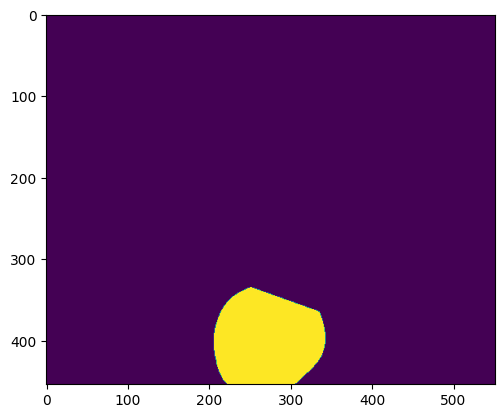

In [16]:
plt.imshow(np.where(masks[0] == 255, 1., 0))

100%|██████████| 200/200 [00:00<00:00, 305.19it/s]

[  0  85 170 255]


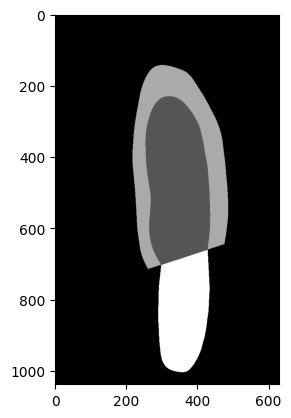

In [19]:
main_path = "data/raw/CAMUS/mhd"

image_paths, mask_paths = get_filepaths(os.path.join(main_path, f"{contour}"), img_format='mhd')
images = get_data(image_paths)
masks = get_data(mask_paths, img_shape=None, as_mask=True)

print(np.unique(masks[52]))
plt.imshow(masks[52], 'gray')

(np.float64(-0.5), np.float64(629.5), np.float64(1037.5), np.float64(-0.5))

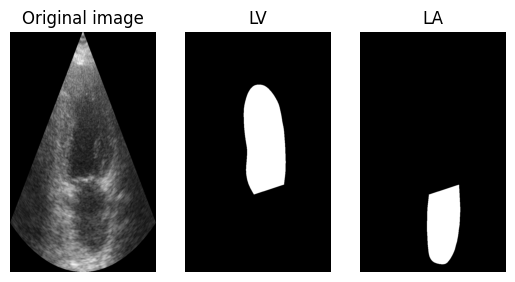

In [20]:
test_LV = np.where(masks[52] == 85, 1, 0) 
test_LA = np.where(masks[52] == 255, 1, 0) 


plt.subplot(131)
plt.imshow(images[52], 'gray')
plt.title("Original image")
plt.axis('off')

plt.subplot(132)
plt.imshow(test_LV, 'gray')
plt.title("LV")
plt.axis('off')

plt.subplot(133)
plt.imshow(test_LA, 'gray')
plt.title('LA')
plt.axis('off')

In [8]:
del images, masks, image_paths, mask_paths

In [9]:
# frames, targets = load_EchoNet()
# frames[0].shape, targets[0].shape

In [10]:
# plt.subplot(121)
# plt.imshow(frames[0])
# plt.subplot(122)
# plt.imshow(targets[0])

In [11]:
# plt.subplot(121)
# plt.imshow(frames[-1])
# plt.subplot(122)
# plt.imshow(targets[-1])

In [22]:
def prepare_dataset(main_path, contour='training'):
    # 
    mhd_path = "data/raw/CAMUS/mhd"
    nifti_path = "data/raw/CAMUS/nifti"

    img_paths, msk_paths = get_filepaths(os.path.join(mhd_path, f"{contour}"), img_format='mhd')

    CAMUS_images = get_data(img_paths, img_shape=(512, 512))
    CAMUS_masks = get_data(msk_paths, img_shape=(512, 512), mask_class=True)

    img_paths, msk_paths = get_filepaths(os.path.join(nifti_path, f"{contour}"), img_format='nii')

    nii_images = get_data(img_paths, img_shape=(512, 512))
    nii_masks = get_data(msk_paths, img_shape=(512, 512), mask_class=True)
    # Concat lists
    images = np.concat([CAMUS_images, nii_images])
    masks = np.concat([CAMUS_masks, nii_masks])

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    dataset = TensorDataset(torch.from_numpy(images), torch.from_numpy(masks))

    return dataset

In [13]:
# imgs, msks = load_EchoNet()

In [14]:
main_path = r'/home/suetin/Docker/Data'
batch_size = 2

train_dataset = prepare_dataset(main_path, contour='training')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = prepare_dataset(main_path, contour='testing')
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/1800 [00:00<?, ?it/s]

100%|██████████| 1800/1800 [00:05<00:00, 317.48it/s]


UnboundLocalError: local variable 'file_names' referenced before assignment

In [8]:
train_loader

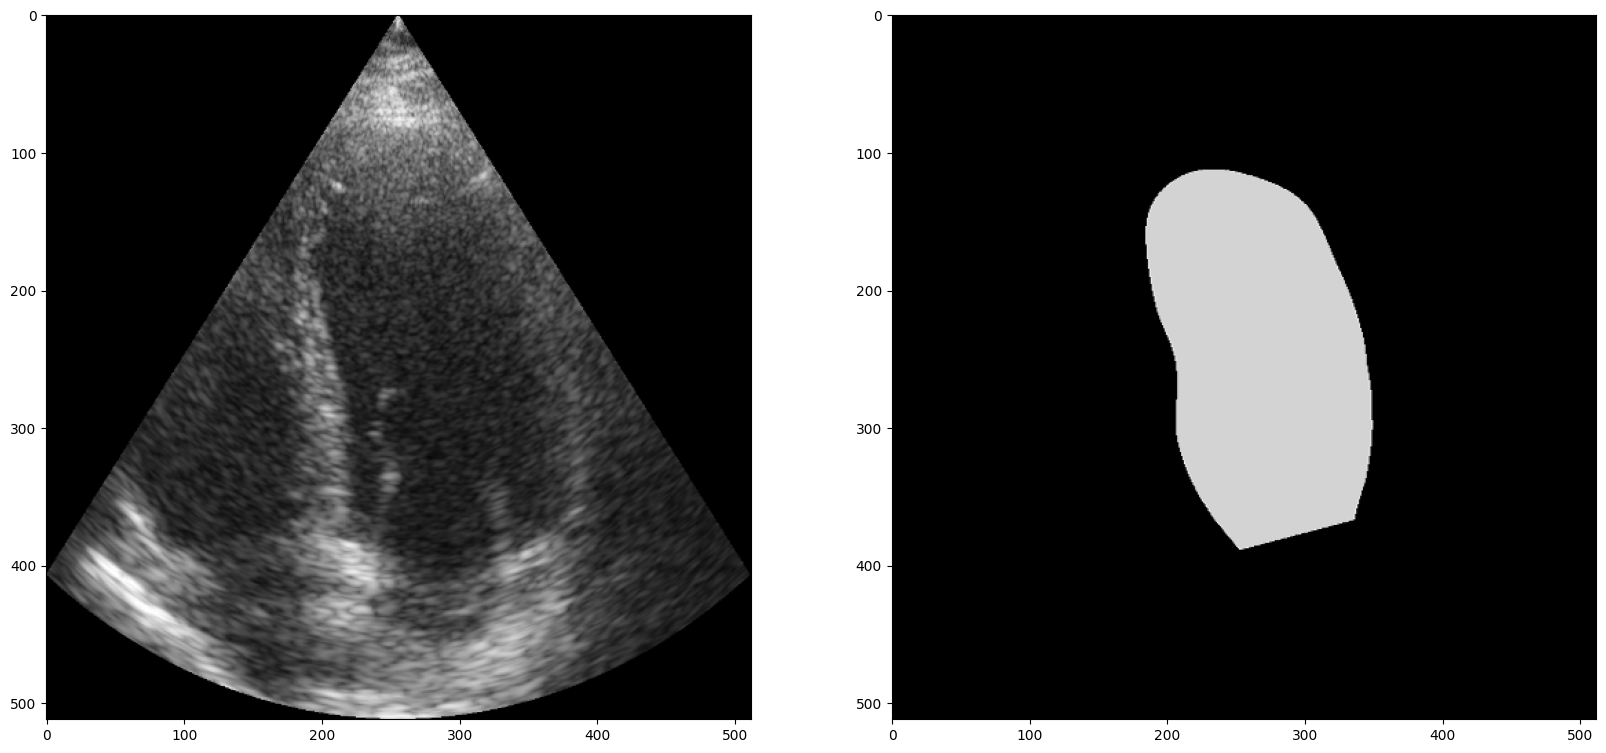

In [9]:
from src.scripts.DataLoaders import ImgForPlot


im, m = train_dataset[25]
fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');

In [ ]:
im, m = train_dataset[-1]
fig = plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(ImgForPlot(im));
plt.subplot(122)
plt.imshow(ImgForPlot(m), 'gray');

In [10]:
im.max(), m.max(), im.shape, m.shape, im.min(), m.min()

(tensor(1.),
 tensor(1.),
 torch.Size([3, 512, 512]),
 torch.Size([1, 512, 512]),
 tensor(0.),
 tensor(0.))

In [11]:
# from torch.utils.data import Dataset, DataLoader


# class MyDataset(Dataset):
#     def __init__(self, data, targets, transform=None):
#         self.data = data
#         self.targets = torch.LongTensor(targets)
#         self.transform = transform
        
#     def __getitem__(self, index):
#         x = self.data[index]
#         y = self.targets[index]
        
#         if self.transform:
#             x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
#             x = self.transform(x)
        
#         return x, y
    
#     def __len__(self):
#         return len(self.data)
    

# transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor()])
# dataset = MyDataset(data, targets, transform=transform)
# dataloader = DataLoader(dataset, batch_size=5)

## Train model

In [12]:
from src.scripts.models.U2Net import U2Net
import pickle
import torch.nn as nn
from src.scripts.losses import IoULoss, DiceBCELoss, DiceLoss

In [13]:
# 
lr = 0.0012

model_saved_dir = "results/U2Net"
if os.path.exists(model_saved_dir) == False:
    os.mkdir(model_saved_dir)
model_name = 'u2net-LA'
loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}_best.pt"
best_model_path = model_path

# with open(loss_path, 'rb') as f:
#   losses = pickle.load(f)

model = U2Net().to(device)
# Continue lerning
# model.load_state_dict(torch.load(model_path))

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

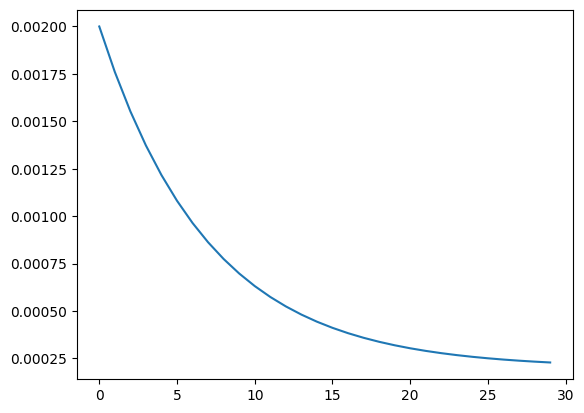

In [14]:
LR_START = 0.002
T_alpha = 7   # Time constant, чем меньше тем быстрее
LOW = 0.0002
epochs = 30

def ws_lr(epoch, lr):
    return (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW

xx = np.arange(30)

plt.plot(xx, [ws_lr(x, 0.01) for x in xx])

In [15]:
import math


def update_lr(epoch, T):
  # Decrease lr every T epochs
  new_lr = (LR_START-LOW) * np.exp(-epoch/T_alpha) + LOW  # lr * math.pow(0.5, epoch // T)
  print('Learning Rate: %.6f' % new_lr)
  for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr

In [16]:
BCE = nn.BCELoss(reduction='mean')  # Train
MAE = nn.L1Loss(reduction='mean')   # Validation
# IoU_loss = IoULoss()
DICE =  DiceLoss()
DBCE = DiceBCELoss()

In [17]:
from time import time

In [21]:
n_print = 400

start_epoch = 0

if start_epoch == 0:
  losses = {'train': [], 'valid': []}
  best_loss = float("inf")
else:
  best_loss = min(losses['valid'])


for ep in range(start_epoch, epochs):
    update_lr(ep, 4)
    step, loss_sum = 0, 0.
    timestamp = time()
    for batch_idx, (input, target) in enumerate(train_loader, 0):
        input = input.to(device)
        target = target.to(device)
        step += 1
        
        # Train Model
        model.train()
        optimizer.zero_grad()
        
        out = model(input)
        # each_loss = [BCE(o.unsqueeze(1), target) for o in out]
        each_loss = [ DBCE(o, target) for o in out ]  
        # each_loss = [ BCE(o, target) for o in out ]  
        loss = sum(each_loss)
        
        loss.backward()
        optimizer.step()

        # Append Loss
        losses['train'].append(loss.item())
        loss_sum += loss.item()

        if (batch_idx+1) % n_print == 0 or batch_idx == (len(train_loader)-1):
            print('[%2d/%2d][%4d/%4d] Train: %.4f (%ds)' % (ep+1, epochs, batch_idx+1, len(train_loader), loss_sum/step, time() - timestamp))
            step, loss_sum = 0, 0.
            timestamp = time()
      
    # Evaluate Model
    model.eval()
    step, loss_sum = 0, 0.
    timestamp = time()
    with torch.no_grad():
        for input, target in tqdm(valid_dataloader):
            out = model(input.to(device))[-1]
            if out.ndim == 3:
                out = out.unsqueeze(1)
            
            loss_sum += DICE(out, target.to(device)).item() * input.size(0)  # MAE(out, target.to(device)).item() * input.size(0)
            step += input.size(0)
      
        val_loss = loss_sum / step
        losses['valid'].append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    print('[%2d/%2d] Valid: %.4f (Best: %.4f) (%ds)' % (ep+1, epochs, val_loss, best_loss, time() - timestamp))

    # torch.save(model.state_dict(), model_path)
    # with open(loss_path, 'wb') as f:
    #     pickle.dump(losses, f)
    
    print("Saved model completely!")

Learning Rate: 0.002000
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


RuntimeError: all elements of input should be between 0 and 1

In [19]:
# import matplotlib


# matplotlib.rcParams.update({'font.size': 13})
# fig = plt.figure(figsize=(15,10))

# N = len(losses['train'])
# y = []
# for i in range(N):
#   y.append(sum([losses['train'][j][i] for j in range(6)]))

# K = 25
# avg = []
# for i in range(K, N-K):
#   avg.append(sum(y[(i-K):(i+K+1)])/(2*K+1))
  
# plt.plot(range(N), y, alpha=0.5)
# plt.plot(range(K, N-K), avg, 'maroon')
# plt.ylim(0, 4)
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Train Loss (Binary Cross Entrophy)')

TypeError: 'float' object is not subscriptable

<Figure size 1500x1000 with 0 Axes>

In [20]:
def prepare_input(img):
    # 
    if img.shape != (512, 512, 3):
        img = cv2.resize(img, (512, 512))

    img = img / 255
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, 0)
    img = img.astype(np.float32)
    img = torch.from_numpy(img).cuda()

    return img

def prepare_output(pred):
    if len(pred) > 1:
        pred = pred[-1]
    if pred.ndim == 4:
        pred = pred[0]

    pred = pred.cpu().detach().numpy()
    pred = sigmoid(pred)
    return np.transpose(pred, (1, 2, 0))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [21]:

# imgage = cv2.cvtColor(cv2.imread(img_test_paths[0]), cv2.COLOR_BGR2RGB)
# new_img = prepare_input(imgage)
# print(new_img.shape)

# msk = cv2.imread(msk_test_paths[0], 0)
# msk = np.where(msk == 255, 255, 0)

pred = model(im.unsqueeze(0).to(device))[-1]
pred = prepare_output(pred)
pred.shape

(512, 512, 1)

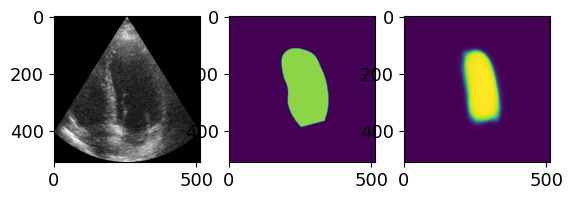

In [22]:
plt.subplot(131)
plt.imshow(ImgForPlot(im));
plt.subplot(132)
plt.imshow(ImgForPlot(m));
plt.subplot(133)
plt.imshow(pred)

(944, 1392, 3)


[mjpeg @ 0x57a6354b0900] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x57a35142e900] unable to decode APP fields: Invalid data found when processing input


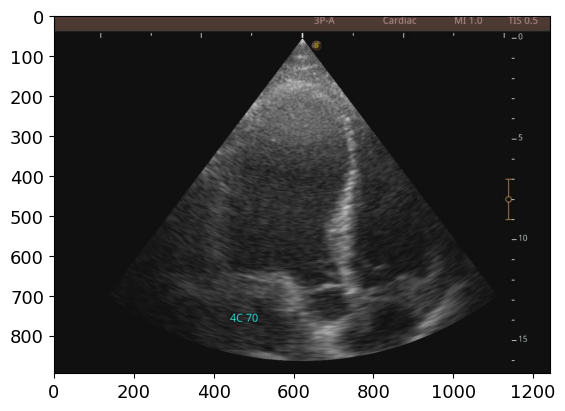

In [23]:
video_name = 'data/temporary/20240708_101231366.avi'

cap = cv2.VideoCapture(video_name)
# cap.set(2, frame_no);
ret, frame = cap.read()
print(frame.shape)
plt.imshow(frame[50:, 150:, :])

torch.Size([1, 3, 512, 512])
(512, 512, 1)


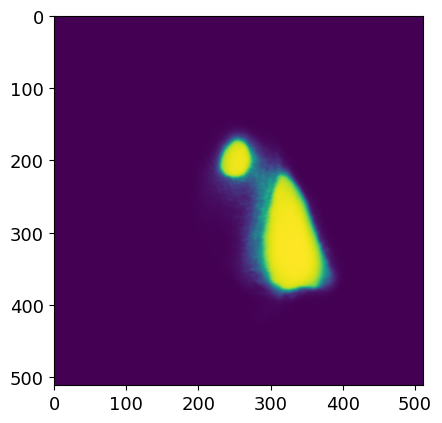

In [24]:
new_img = prepare_input(frame[50:, 150:, :])
print(new_img.shape)
pred = model(new_img)[-1]
pred = prepare_output(pred)
print(pred.shape)

plt.imshow(pred)